In [1]:
import numpy as np
import pandas as pd
import tcbench as tcb
from functions import (extract_results_limits_per_class,
                       extract_results_limits_per_class_splits_avg,
                       plot_results_limits_per_class)

In [2]:
vectors_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_labels.npy')
vectors_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_labels.npy')

In [3]:
df_split = tcb.load_parquet(tcb.DATASETS.MIRAGE19, min_pkts=10, split=True)
train_val_indices = np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]])
test_indices = df_split.iloc[0][2]

In [4]:
samples = [10, 100, 1000]
percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]

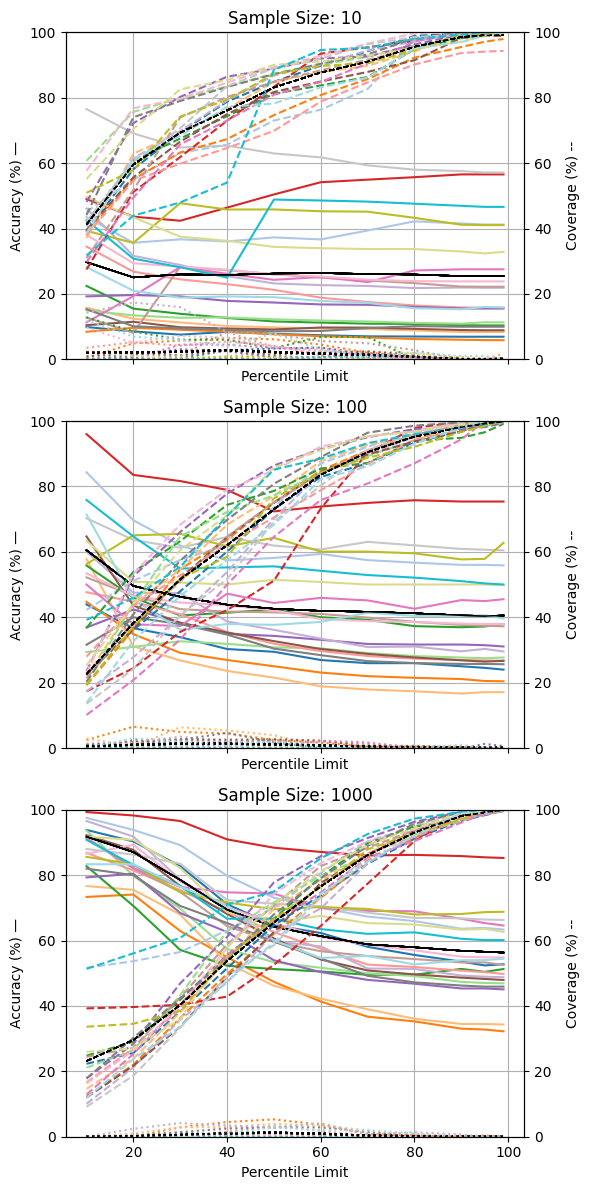

In [5]:
coverage_results_baseline_limits_per_class, accuracy_results_baseline_limits_per_class, missed_results_baseline_limits_per_class = extract_results_limits_per_class(vectors_baseline, labels_baseline, train_val_indices, test_indices, 'euclidean', 'distance', samples, percentiles)
plot_results_limits_per_class(coverage_results_baseline_limits_per_class, accuracy_results_baseline_limits_per_class, missed_results_baseline_limits_per_class, samples, percentiles)

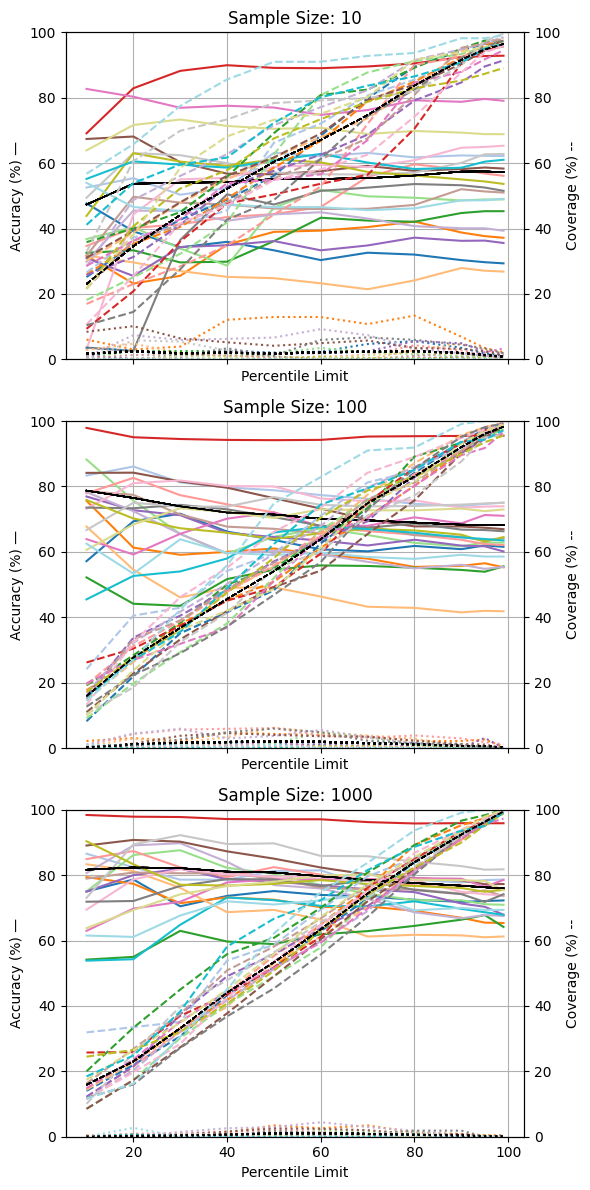

In [6]:
coverage_results_embeddings_limits_per_class, accuracy_results_embeddings_limits_per_class, missed_results_embeddings_limits_per_class = extract_results_limits_per_class(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'euclidean', 'distance', samples, percentiles)
plot_results_limits_per_class(coverage_results_embeddings_limits_per_class, accuracy_results_embeddings_limits_per_class, missed_results_embeddings_limits_per_class, samples, percentiles)

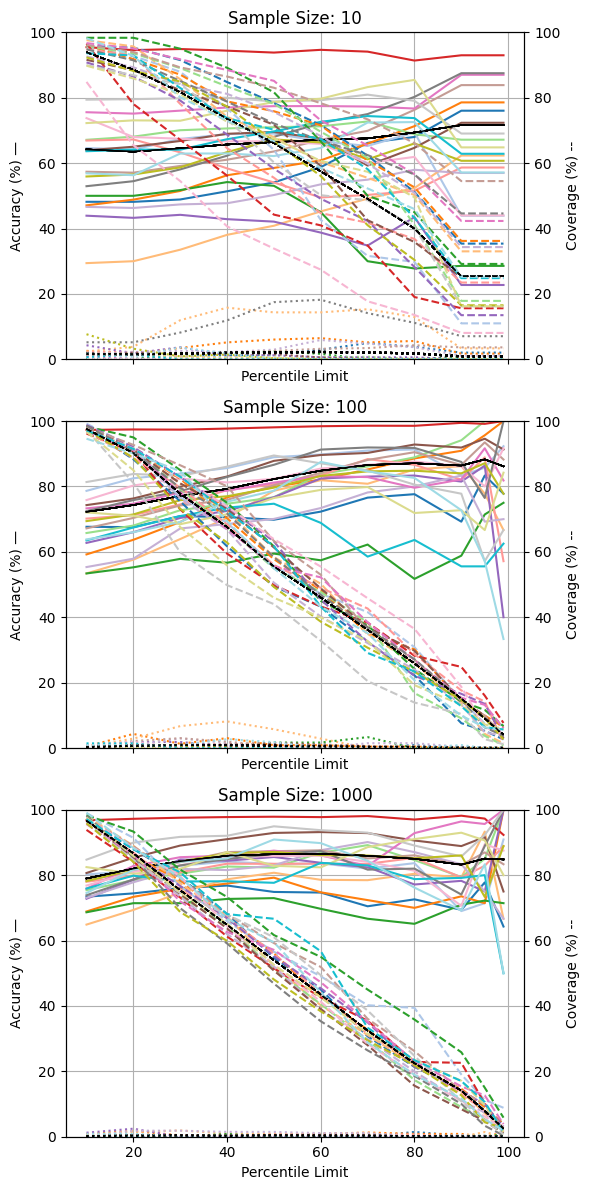

In [7]:
coverage_results_embeddings_cosine_limits_per_class, accuracy_results_embeddings_cosine_limits_per_class, missed_results_embeddings_cosine_limits_per_class = extract_results_limits_per_class(vectors_embeddings, labels_embeddings, train_val_indices, test_indices, 'cosine', 'similarity', samples, percentiles)
plot_results_limits_per_class(coverage_results_embeddings_cosine_limits_per_class, accuracy_results_embeddings_cosine_limits_per_class, missed_results_embeddings_cosine_limits_per_class, samples, percentiles)

In [8]:
train_test_splits = [
    (np.concatenate([df_split.iloc[0][0], df_split.iloc[0][1]]), df_split.iloc[0][2]),
    (np.concatenate([df_split.iloc[1][0], df_split.iloc[1][1]]), df_split.iloc[1][2]),
    (np.concatenate([df_split.iloc[2][0], df_split.iloc[2][1]]), df_split.iloc[2][2]),
    (np.concatenate([df_split.iloc[3][0], df_split.iloc[3][1]]), df_split.iloc[3][2]),
    (np.concatenate([df_split.iloc[4][0], df_split.iloc[4][1]]), df_split.iloc[4][2])
]

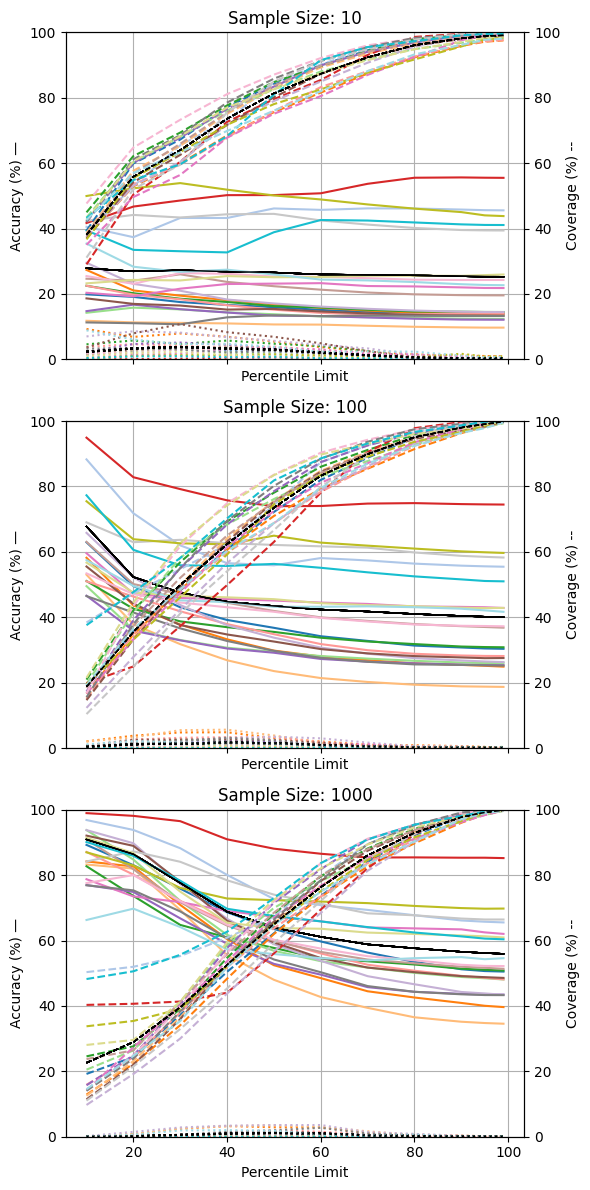

In [9]:
coverage_results_baseline_limits_per_class_splits_avg, accuracy_results_baseline_limits_per_class_splits_avg, missed_results_baseline_limits_per_class_splits_avg = extract_results_limits_per_class_splits_avg(vectors_baseline, labels_baseline, train_test_splits, 'euclidean', 'distance', samples, percentiles)
plot_results_limits_per_class(coverage_results_baseline_limits_per_class_splits_avg, accuracy_results_baseline_limits_per_class_splits_avg, missed_results_baseline_limits_per_class_splits_avg, samples, percentiles)

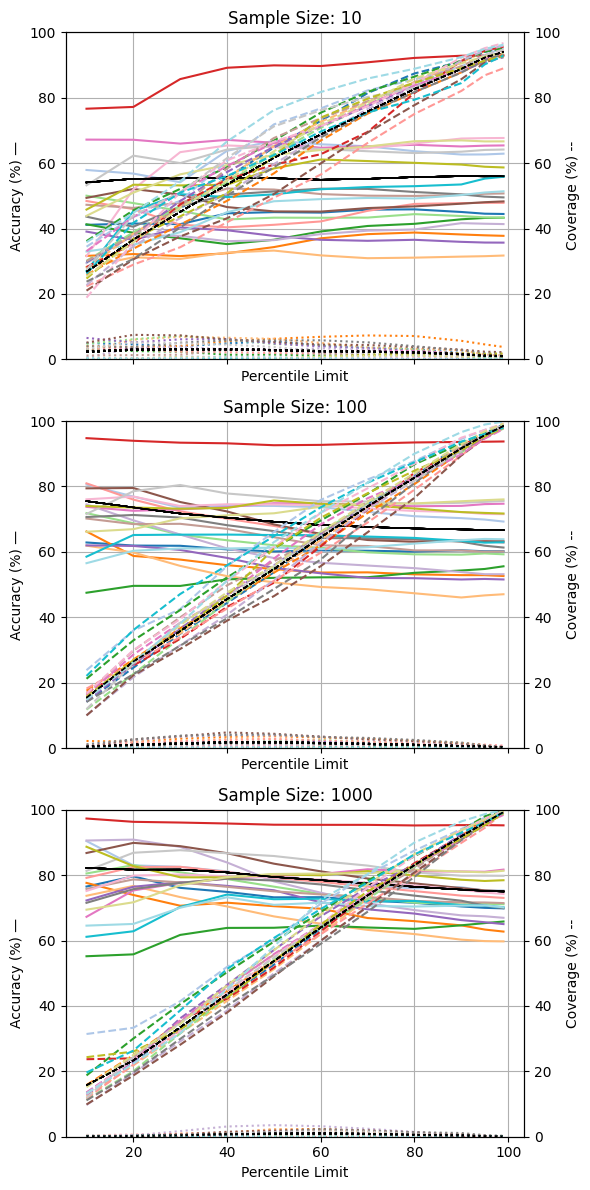

In [10]:
coverage_results_embeddings_limits_per_class_splits_avg, accuracy_results_embeddings_limits_per_class_splits_avg, missed_results_embeddings_limits_per_class_splits_avg = extract_results_limits_per_class_splits_avg(vectors_embeddings, labels_embeddings, train_test_splits, 'euclidean', 'distance', samples, percentiles)
plot_results_limits_per_class(coverage_results_embeddings_limits_per_class_splits_avg, accuracy_results_embeddings_limits_per_class_splits_avg, missed_results_embeddings_limits_per_class_splits_avg, samples, percentiles)

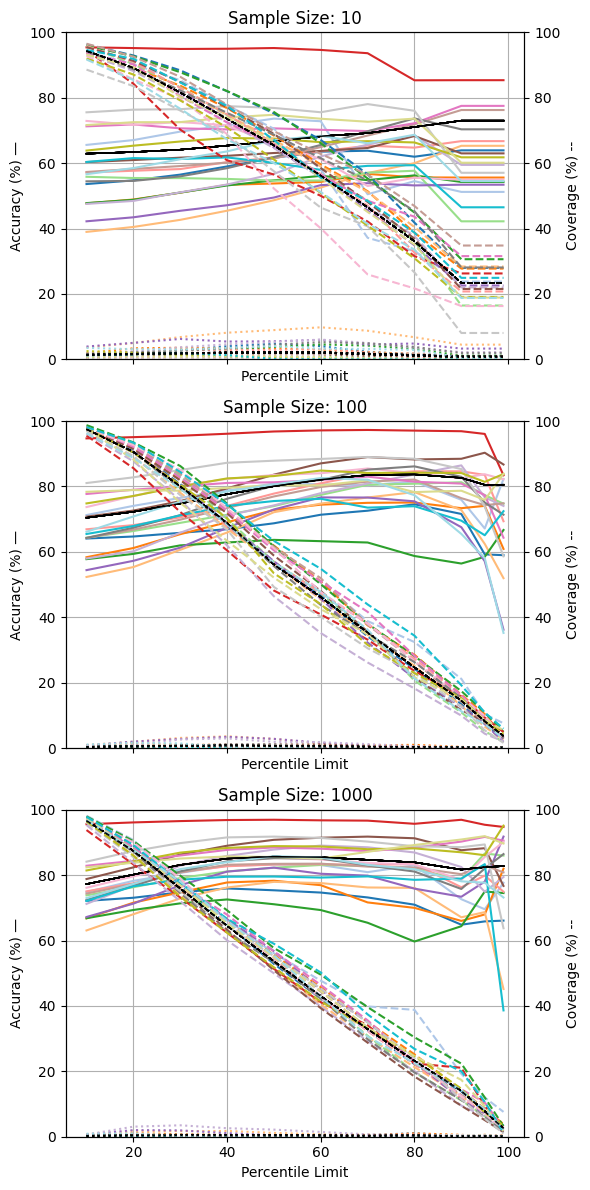

In [11]:
coverage_results_embeddings_cosine_limits_per_class_splits_avg, accuracy_results_embeddings_cosine_limits_per_class_splits_avg, missed_results_embeddings_cosine_limits_per_class_splits_avg = extract_results_limits_per_class_splits_avg(vectors_embeddings, labels_embeddings, train_test_splits, 'cosine', 'similarity', samples, percentiles)
plot_results_limits_per_class(coverage_results_embeddings_cosine_limits_per_class_splits_avg, accuracy_results_embeddings_cosine_limits_per_class_splits_avg, missed_results_embeddings_cosine_limits_per_class_splits_avg, samples, percentiles)

In [12]:
sample_size = 100

classes = sorted(coverage_results_embeddings_limits_per_class_splits_avg[percentiles[0]][sample_size].keys())
data = []

for class_label in classes:
    row = []
    for percentile in percentiles:
        coverage = coverage_results_embeddings_limits_per_class_splits_avg[percentile][sample_size].get(class_label, [0])[0]
        accuracy = accuracy_results_embeddings_limits_per_class_splits_avg[percentile][sample_size].get(class_label, [0])[0]
        missed = missed_results_embeddings_limits_per_class_splits_avg[percentile][sample_size].get(class_label, [0])[0]
        row.append(f"Cov: {coverage:.2f}%\nAcc: {accuracy:.2f}%\nMiss: {missed:.2f}%")
    data.append(row)

columns = [f"Percentile_{p}" for p in percentiles]
df = pd.DataFrame(data, columns=columns, index=[("Total" if c == -1 else f"Class_{c}") for c in classes])

df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector='th', props=[('text-align', 'left')])
])

,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_95,Percentile_99
Total,Cov: 15.34% Acc: 75.50% Miss: 0.33%,Cov: 26.42% Acc: 73.58% Miss: 0.94%,Cov: 35.76% Acc: 71.70% Miss: 1.37%,Cov: 45.57% Acc: 70.46% Miss: 1.71%,Cov: 54.72% Acc: 69.21% Miss: 1.72%,Cov: 64.47% Acc: 68.21% Miss: 1.50%,Cov: 73.90% Acc: 67.60% Miss: 1.24%,Cov: 82.67% Acc: 67.15% Miss: 0.94%,Cov: 91.65% Acc: 66.86% Miss: 0.56%,Cov: 95.70% Acc: 66.70% Miss: 0.35%,Cov: 98.45% Acc: 66.65% Miss: 0.18%
Class_0,Cov: 14.13% Acc: 62.86% Miss: 0.25%,Cov: 24.55% Acc: 61.91% Miss: 0.54%,Cov: 34.93% Acc: 61.85% Miss: 1.19%,Cov: 44.38% Acc: 60.74% Miss: 1.32%,Cov: 53.75% Acc: 60.12% Miss: 1.08%,Cov: 64.74% Acc: 60.44% Miss: 1.08%,Cov: 74.49% Acc: 60.33% Miss: 0.98%,Cov: 83.11% Acc: 60.08% Miss: 0.71%,Cov: 93.11% Acc: 60.48% Miss: 0.47%,Cov: 96.31% Acc: 60.17% Miss: 0.30%,Cov: 98.91% Acc: 60.18% Miss: 0.15%
Class_1,Cov: 23.80% Acc: 80.57% Miss: 0.00%,Cov: 35.92% Acc: 76.91% Miss: 0.00%,Cov: 42.48% Acc: 73.49% Miss: 0.00%,Cov: 55.63% Acc: 74.09% Miss: 0.00%,Cov: 66.09% Acc: 74.05% Miss: 0.01%,Cov: 75.88% Acc: 73.66% Miss: 0.07%,Cov: 82.13% Acc: 72.23% Miss: 0.11%,Cov: 87.73% Acc: 70.89% Miss: 0.12%,Cov: 94.54% Acc: 70.30% Miss: 0.05%,Cov: 97.31% Acc: 69.87% Miss: 0.02%,Cov: 98.95% Acc: 69.26% Miss: 0.01%
Class_2,Cov: 17.54% Acc: 66.23% Miss: 2.14%,Cov: 27.04% Acc: 58.74% Miss: 1.93%,Cov: 36.63% Acc: 57.63% Miss: 2.87%,Cov: 45.02% Acc: 55.91% Miss: 3.43%,Cov: 53.62% Acc: 54.74% Miss: 3.60%,Cov: 62.06% Acc: 53.66% Miss: 3.20%,Cov: 71.89% Acc: 53.72% Miss: 2.87%,Cov: 80.74% Acc: 53.12% Miss: 2.23%,Cov: 90.57% Acc: 52.87% Miss: 1.56%,Cov: 95.48% Acc: 52.86% Miss: 0.90%,Cov: 98.60% Acc: 52.60% Miss: 0.33%
Class_3,Cov: 15.18% Acc: 61.88% Miss: 0.37%,Cov: 26.86% Acc: 59.79% Miss: 1.81%,Cov: 35.04% Acc: 55.70% Miss: 2.12%,Cov: 45.42% Acc: 52.56% Miss: 2.79%,Cov: 54.33% Acc: 50.67% Miss: 2.75%,Cov: 63.59% Acc: 49.26% Miss: 2.26%,Cov: 73.63% Acc: 48.56% Miss: 2.08%,Cov: 82.78% Acc: 47.33% Miss: 1.56%,Cov: 92.41% Acc: 46.04% Miss: 0.45%,Cov: 96.75% Acc: 46.68% Miss: 0.34%,Cov: 99.02% Acc: 47.03% Miss: 0.06%
Class_4,Cov: 21.18% Acc: 47.49% Miss: 0.08%,Cov: 32.91% Acc: 49.59% Miss: 0.17%,Cov: 42.21% Acc: 49.57% Miss: 0.37%,Cov: 52.18% Acc: 51.59% Miss: 0.38%,Cov: 61.03% Acc: 52.04% Miss: 0.43%,Cov: 69.60% Acc: 52.20% Miss: 0.49%,Cov: 77.70% Acc: 52.23% Miss: 0.30%,Cov: 86.76% Acc: 53.58% Miss: 0.35%,Cov: 93.15% Acc: 54.29% Miss: 0.16%,Cov: 96.21% Acc: 54.76% Miss: 0.02%,Cov: 98.77% Acc: 55.58% Miss: 0.08%
Class_5,Cov: 11.75% Acc: 71.83% Miss: 0.34%,Cov: 22.63% Acc: 68.74% Miss: 0.72%,Cov: 33.60% Acc: 65.21% Miss: 1.16%,Cov: 44.73% Acc: 63.54% Miss: 1.73%,Cov: 55.04% Acc: 62.01% Miss: 2.16%,Cov: 66.03% Acc: 61.24% Miss: 2.45%,Cov: 74.57% Acc: 59.85% Miss: 1.67%,Cov: 82.69% Acc: 59.24% Miss: 1.22%,Cov: 90.41% Acc: 59.12% Miss: 0.60%,Cov: 95.07% Acc: 59.50% Miss: 0.56%,Cov: 97.69% Acc: 59.24% Miss: 0.24%
Class_6,Cov: 16.85% Acc: 94.77% Miss: 0.00%,Cov: 25.22% Acc: 93.97% Miss: 0.00%,Cov: 33.40% Acc: 93.39% Miss: 0.00%,Cov: 43.18% Acc: 93.19% Miss: 0.00%,Cov: 50.55% Acc: 92.61% Miss: 0.00%,Cov: 61.68% Acc: 92.71% Miss: 0.00%,Cov: 72.95% Acc: 93.11% Miss: 0.00%,Cov: 84.16% Acc: 93.45% Miss: 0.00%,Cov: 91.43% Acc: 93.61% Miss: 0.00%,Cov: 94.82% Acc: 93.68% Miss: 0.00%,Cov: 98.21% Acc: 93.75% Miss: 0.01%
Class_7,Cov: 18.17% Acc: 80.94% Miss: 0.91%,Cov: 26.03% Acc: 75.98% Miss: 1.59%,Cov: 33.90% Acc: 72.38% Miss: 2.07%,Cov: 42.67% Acc: 70.13% Miss: 2.46%,Cov: 51.13% Acc: 67.93% Miss: 2.74%,Cov: 59.75% Acc: 65.37% Miss: 2.26%,Cov: 68.97% Acc: 64.09% Miss: 1.84%,Cov: 79.01% Acc: 63.75% Miss: 1.45%,Cov: 89.45% Acc: 63.27% Miss: 0.95%,Cov: 94.98% Acc: 63.32% Miss: 1.02%,Cov: 97.84% Acc: 62.82% Miss: 0.72%
Class_8,Cov: 14.23% Acc: 61.97% Miss: 0.34%,Cov: 25.56% Acc: 61.80% Miss: 0.82%,Cov: 36.43% Acc: 60.58% Miss: 1.57%,Cov: 46.99% Acc: 58.14% Miss: 1.79%,Cov: 55.86% Acc: 55.10% Miss: 1.91%,Cov: 65.49% Acc: 53.44%

In [13]:
sample_size = 100

classes = sorted(coverage_results_embeddings_cosine_limits_per_class_splits_avg[percentiles[0]][sample_size].keys())
data = []

for class_label in classes:
    row = []
    for percentile in percentiles:
        coverage = coverage_results_embeddings_cosine_limits_per_class_splits_avg[percentile][sample_size].get(class_label, [0])[0]
        accuracy = accuracy_results_embeddings_cosine_limits_per_class_splits_avg[percentile][sample_size].get(class_label, [0])[0]
        missed = missed_results_embeddings_cosine_limits_per_class_splits_avg[percentile][sample_size].get(class_label, [0])[0]
        row.append(f"Cov: {coverage:.2f}%\nAcc: {accuracy:.2f}%\nMiss: {missed:.2f}%")
    data.append(row)

columns = [f"Percentile_{p}" for p in percentiles]
df = pd.DataFrame(data, columns=columns, index=[("Total" if c == -1 else f"Class_{c}") for c in classes])

df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector='th', props=[('text-align', 'left')])
])

,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_95,Percentile_99
Total,Cov: 97.51% Acc: 70.42% Miss: 0.28%,Cov: 90.54% Acc: 72.26% Miss: 0.49%,Cov: 80.03% Acc: 74.77% Miss: 0.63%,Cov: 68.73% Acc: 77.63% Miss: 0.73%,Cov: 56.17% Acc: 80.08% Miss: 0.59%,Cov: 46.15% Acc: 82.10% Miss: 0.46%,Cov: 35.32% Acc: 83.48% Miss: 0.31%,Cov: 24.65% Acc: 83.69% Miss: 0.18%,Cov: 14.49% Acc: 82.62% Miss: 0.08%,Cov: 8.21% Acc: 80.50% Miss: 0.07%,Cov: 3.66% Acc: 80.54% Miss: 0.02%
Class_0,Cov: 98.12% Acc: 64.07% Miss: 0.15%,Cov: 91.27% Acc: 64.69% Miss: 0.07%,Cov: 80.75% Acc: 65.81% Miss: 0.25%,Cov: 68.69% Acc: 66.92% Miss: 0.39%,Cov: 56.10% Acc: 68.73% Miss: 0.47%,Cov: 46.64% Acc: 71.35% Miss: 0.59%,Cov: 34.12% Acc: 72.58% Miss: 0.39%,Cov: 24.25% Acc: 74.54% Miss: 0.44%,Cov: 13.42% Acc: 71.59% Miss: 0.20%,Cov: 7.34% Acc: 59.22% Miss: 0.17%,Cov: 2.97% Acc: 58.98% Miss: 0.06%
Class_1,Cov: 98.00% Acc: 71.25% Miss: 0.25%,Cov: 92.49% Acc: 74.06% Miss: 0.37%,Cov: 82.69% Acc: 76.50% Miss: 0.16%,Cov: 72.02% Acc: 78.76% Miss: 0.08%,Cov: 61.89% Acc: 80.88% Miss: 0.05%,Cov: 50.51% Acc: 80.68% Miss: 0.02%,Cov: 38.82% Acc: 80.35% Miss: 0.00%,Cov: 32.40% Acc: 81.52% Miss: 0.00%,Cov: 21.15% Acc: 75.92% Miss: 0.00%,Cov: 10.36% Acc: 67.14% Miss: 0.00%,Cov: 7.56% Acc: 82.28% Miss: 0.00%
Class_2,Cov: 98.24% Acc: 58.36% Miss: 0.73%,Cov: 91.62% Acc: 61.16% Miss: 1.51%,Cov: 82.03% Acc: 65.39% Miss: 0.98%,Cov: 71.99% Acc: 69.05% Miss: 0.99%,Cov: 61.87% Acc: 72.80% Miss: 0.76%,Cov: 50.96% Acc: 74.43% Miss: 0.69%,Cov: 37.53% Acc: 74.99% Miss: 0.81%,Cov: 28.51% Acc: 75.09% Miss: 0.97%,Cov: 16.27% Acc: 73.35% Miss: 0.34%,Cov: 10.38% Acc: 74.06% Miss: 0.16%,Cov: 3.39% Acc: 60.89% Miss: 0.05%
Class_3,Cov: 97.13% Acc: 52.31% Miss: 0.91%,Cov: 88.98% Acc: 55.34% Miss: 1.91%,Cov: 78.07% Acc: 60.62% Miss: 3.08%,Cov: 67.15% Acc: 65.90% Miss: 3.58%,Cov: 56.22% Acc: 72.12% Miss: 2.80%,Cov: 45.43% Acc: 74.76% Miss: 1.39%,Cov: 34.63% Acc: 76.62% Miss: 0.61%,Cov: 25.17% Acc: 78.27% Miss: 0.33%,Cov: 12.88% Acc: 72.77% Miss: 0.14%,Cov: 6.51% Acc: 62.42% Miss: 0.06%,Cov: 2.56% Acc: 51.94% Miss: 0.07%
Class_4,Cov: 98.75% Acc: 57.76% Miss: 0.19%,Cov: 93.48% Acc: 59.37% Miss: 0.23%,Cov: 86.26% Acc: 61.97% Miss: 0.44%,Cov: 74.75% Acc: 62.86% Miss: 0.27%,Cov: 61.64% Acc: 63.66% Miss: 0.38%,Cov: 50.10% Acc: 63.26% Miss: 0.56%,Cov: 37.97% Acc: 62.85% Miss: 0.49%,Cov: 28.09% Acc: 58.72% Miss: 0.17%,Cov: 17.41% Acc: 56.42% Miss: 0.19%,Cov: 10.86% Acc: 58.47% Miss: 0.06%,Cov: 4.96% Acc: 66.68% Miss: 0.02%
Class_5,Cov: 98.04% Acc: 64.33% Miss: 0.28%,Cov: 92.98% Acc: 66.36% Miss: 0.76%,Cov: 83.22% Acc: 68.86% Miss: 0.67%,Cov: 70.04% Acc: 71.33% Miss: 0.42%,Cov: 56.99% Acc: 73.99% Miss: 0.21%,Cov: 47.32% Acc: 77.41% Miss: 0.21%,Cov: 35.59% Acc: 80.51% Miss: 0.26%,Cov: 20.61% Acc: 80.83% Miss: 0.11%,Cov: 10.90% Acc: 81.29% Miss: 0.09%,Cov: 5.17% Acc: 77.34% Miss: 0.09%,Cov: 1.84% Acc: 74.72% Miss: 0.01%
Class_6,Cov: 95.54% Acc: 94.69% Miss: 0.00%,Cov: 85.61% Acc: 95.07% Miss: 0.00%,Cov: 72.21% Acc: 95.50% Miss: 0.00%,Cov: 60.43% Acc: 96.12% Miss: 0.00%,Cov: 48.15% Acc: 96.81% Miss: 0.00%,Cov: 40.84% Acc: 97.14% Miss: 0.00%,Cov: 33.14% Acc: 97.27% Miss: 0.00%,Cov: 23.56% Acc: 97.08% Miss: 0.00%,Cov: 15.77% Acc: 96.89% Miss: 0.00%,Cov: 9.30% Acc: 96.06% Miss: 0.00%,Cov: 4.88% Acc: 83.41% Miss: 0.00%
Class_7,Cov: 97.94% Acc: 66.90% Miss: 0.17%,Cov: 91.60% Acc: 68.17% Miss: 0.29%,Cov: 79.95% Acc: 70.53% Miss: 0.49%,Cov: 67.83% Acc: 74.05% Miss: 0.85%,Cov: 56.75% Acc: 77.82% Miss: 0.81%,Cov: 47.39% Acc: 80.96% Miss: 0.53%,Cov: 38.04% Acc: 83.74% Miss: 0.41%,Cov: 27.27% Acc: 84.62% Miss: 0.22%,Cov: 15.93% Acc: 84.63% Miss: 0.19%,Cov: 9.55% Acc: 83.52% Miss: 0.26%,Cov: 2.84% Acc: 69.36% Miss: 0.07%
Class_8,Cov: 97.76% Acc: 54.40% Miss: 0.77%,Cov: 90.52% Acc: 57.25% Miss: 1.96%,Cov: 80.56% Acc: 61.28% Miss: 2.77%,Cov: 68.73% Acc: 67.34% Miss: 3.41%,Cov: 57.12% Acc: 72.96% Miss: 2.79%,Cov: 45.70% Acc: 76.64% Miss: 1.61%,Co